<a href="https://colab.research.google.com/github/arnejad/Facial-Keypoint-Detection/blob/master/Facial_Keypoint_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Facial Keypoint Detections - Kaggle challenge**
The code is divided into n parts.
- Loading Data from Kaggle API
- Data Preparation
- Visualization
- Data Augmentation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
from time import sleep
import os
import random

### **Loading Data from Kaggle into notebook** (one time execution)


In [ ]:
! pip install kaggle
!mkdir -p ~/.kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ashnejad","key":"249dcaf84b862004c36c1fb1ff6dd01a"}'}

In [ ]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c facial-keypoints-detection

  0% 0.00/201k [00:00<?, ?B/s]
100% 201k/201k [00:00<00:00, 77.3MB/s]
 68% 41.0M/60.1M [00:01<00:00, 27.7MB/s]
100% 60.1M/60.1M [00:01<00:00, 47.9MB/s]
 81% 13.0M/16.0M [00:00<00:00, 13.4MB/s]
100% 16.0M/16.0M [00:00<00:00, 17.4MB/s]
  0% 0.00/843k [00:00<?, ?B/s]
100% 843k/843k [00:00<00:00, 119MB/s]


In [ ]:
# Unpacking downloaded zips
# The output must contain test.csv,  training.csv,  IdLookupTable.csv
!unzip -q training.zip -d .
!unzip -q test.zip -d .
!ls

IdLookupTable.csv  sample_data		 test.csv  training.csv
kaggle.json	   SampleSubmission.csv  test.zip  training.zip


### **Data Preparation**


In [ ]:
Train_Dir = 'training.csv'
Test_Dir = 'test.csv'
lookid_dir = 'IdLookupTable.csv'
train = pd.read_csv(Train_Dir)  
test = pd.read_csv(Test_Dir)
lookid = pd.read_csv(lookid_dir)


In [ ]:
# a preview of the data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

In the following section, the train data frame is splited into two dataframes, one containing images, the other containing key-points info.

In [ ]:
img_df = train[["Image"]]     # images dataset
points_df = train.drop("Image",axis=1)   # key-points dataset
img_df.head(5)                 # logging the first five images

,Image
0,238 236 237 238 240 240 239 241 241 243 240 23...
1,219 215 204 196 204 211 212 200 180 168 178 19...
2,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,147 148 160 196 215 214 216 217 219 220 206 18...


The elimination of rows with NaN values have reduced our original data to less than a third. Since the data volume is vital for a Deep Learning system we filled Nan values in keypoins with mean of corresponding column( Images column doesn't have any Nan value).


In [ ]:
points_df = points_df.fillna(points_df.mean())
points_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7049 non-null   float64
 1   left_eye_center_y          7049 non-null   float64
 2   right_eye_center_x         7049 non-null   float64
 3   right_eye_center_y         7049 non-null   float64
 4   left_eye_inner_corner_x    7049 non-null   float64
 5   left_eye_inner_corner_y    7049 non-null   float64
 6   left_eye_outer_corner_x    7049 non-null   float64
 7   left_eye_outer_corner_y    7049 non-null   float64
 8   right_eye_inner_corner_x   7049 non-null   float64
 9   right_eye_inner_corner_y   7049 non-null   float64
 10  right_eye_outer_corner_x   7049 non-null   float64
 11  right_eye_outer_corner_y   7049 non-null   float64
 12  left_eyebrow_inner_end_x   7049 non-null   float64
 13  left_eyebrow_inner_end_y   7049 non-null   float

Next, We will reform the images from string to matrix representation.

In [ ]:
imgs = []
for i in range(0,train.shape[0]):
    img = np.reshape(np.array(img_df["Image"][i].split(' '), dtype='float'), (96,96))
    imgs.append(img)

imgs = np.array(imgs)/255.

# each row of points should be conveted to a list.
points = points_df.values.tolist()

### **Visualization**

Now that the images are read and transformed to the proper structure we define a function for visulizaing an image with its key-points


In [ ]:
def viualizeImageWithKeyPoints(img, keypoints, axis):
  axis.imshow(img, cmap='gray')
  axis.scatter(keypoints[::2], keypoints[1::2], marker='o', s=20)   #splits to Ys and Xs and shows


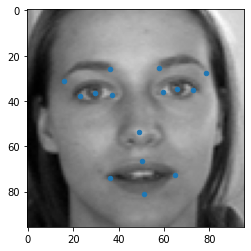

In [ ]:
viualizeImageWithKeyPoints(imgs[158], points[158], plt)

### **Data Augmentation**

In this section, we are going to use the idea which AlexNet used to produce a feature invariant to transformation. For more info, take a look at [this link](https://link.springer.com/article/10.1186/s40537-019-0197-0)

For this purpose, we transofrm each image to a 85-in-85 size and place it randomly in an area in the original in a way that contains most od

In [ ]:
def imageAugmentation(img, kps,maxCropSize = 10):
  res_imgs=[]
  res_pnts=[]
  for i in range(4):
    x_tr = random.randint(-maxCropSize,maxCropSize)
    y_tr = random.randint(-maxCropSize,maxCropSize)
    im = img[maxCropSize+int(y_tr/2):(96-(maxCropSize-int(y_tr/2))),
             maxCropSize+int(x_tr/2):(96-(maxCropSize-int(x_tr/2)))]# value of crop from left, top, right, bottom respectivley


    # calculate the new position of the key-points
    y_tr=int(maxCropSize) + int(y_tr/2)
    x_tr=int(maxCropSize) + int(x_tr/2)
    pnts_tr = kps - np.array([x_tr,y_tr]*15)
    res_imgs.append(im.reshape(96-(2*maxCropSize),96-(2*maxCropSize)))
    res_pnts.append(pnts_tr)
    #viualizeImageWithKeyPoints(im, pnts_tr, plt)

  return np.array(res_imgs), np.array(res_pnts)

Creating the final augmented images dataset


In [ ]:
finalImgs,finalPnts = list(zip(*[imageAugmentation(img,p) for img,p in zip(imgs,points)]))
finalImgs= np.concatenate(finalImgs)
finalPnts = np.concatenate(finalPnts)

print(finalImgs.shape)
print(finalPnts.shape)


(28196, 76, 76)
(28196, 30)


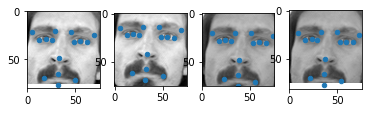

In [ ]:
# making sure everything is in the right place
fig, axis = plt.subplots(1, 4)
# axis[2]
for i in range(0,4):
  viualizeImageWithKeyPoints(finalImgs[i], finalPnts[i], axis[i])

###**Deep Learning**

Now that the data is ready, we can use the Deep Learning method.
What we propose is using Convolutional Neural Networks for to transform image into a flatten representation followed by an LSTM network. In the LSTM, each cell is responsible for learning one key-point. The order of the cells is importnat. Considering the forgetting of an LSTM system, the best practice is to put the order of the key-points in a sequance that forgeting the input image along the LSTM costs less inaccuracy. For instance, since having key-points in the left-side of face helps in producing the right-side key-points of the face, the right-side points should be learnt first.

#### **CNN**

This network is comprised of ...  TODO

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten#create model

model = Sequential()

#CNN
model.add(Conv2D(64, kernel_size=3, activation='tanh', input_shape=(96-(2*maxCropSize),96-(2*maxCropSize),1)))
model.add(Conv2D(32, kernel_size=3, activation='tanh'))
model.add(Flatten())
model.add(Dense(10, activation=’softmax’))


#### **LSTM**

In [ ]:
# LSTM


#### **Compile and Train**

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])